In [3]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,precision_score, recall_score
import numpy as np

In [4]:
df = pd.read_csv('/Users/shravaninomulwar/Desktop/abc/dataset/creditcardfraud-csv/creditcard.csv')

# 1. Separate features (X) and target (y)
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']
x_train, x_test, y_train, y_test = train_test_split(X, y,random_state=42)


In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
x_train_normal = x_train[y_train==0]
x_test_normal = x_test[y_test==0]
x_test_anomaly = x_test[y_test==1]

In [11]:
input_dim = x_train_normal.shape[1]

In [13]:
print(input_dim)

29


In [ ]:

bottleneck = 14

input_layer = Input(shape=(input_dim,))

encoder = Dense(20, activation='relu')(input_layer)
encoder = Dense(bottleneck, activation='relu')(encoder)

decoder = Dense(20, activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(input_layer, decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(x_train_normal, x_train_normal, epochs=20, validation_split=0.1)


Epoch 1/20
5997/5997 ━━━━━━━━━━━━━━━━━━━━ 2s 315us/step - loss: 205.6135 - val_loss: 0.6993
Epoch 2/20
5997/5997 ━━━━━━━━━━━━━━━━━━━━ 2s 314us/step - loss: 2.5524 - val_loss: 0.6034
Epoch 3/20
5997/5997 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step - loss: 3.0014 - val_loss: 0.5554
Epoch 4/20
5997/5997 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step - loss: 1.0429 - val_loss: 8.8797
Epoch 5/20
3171/5997 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - loss: 1.0904

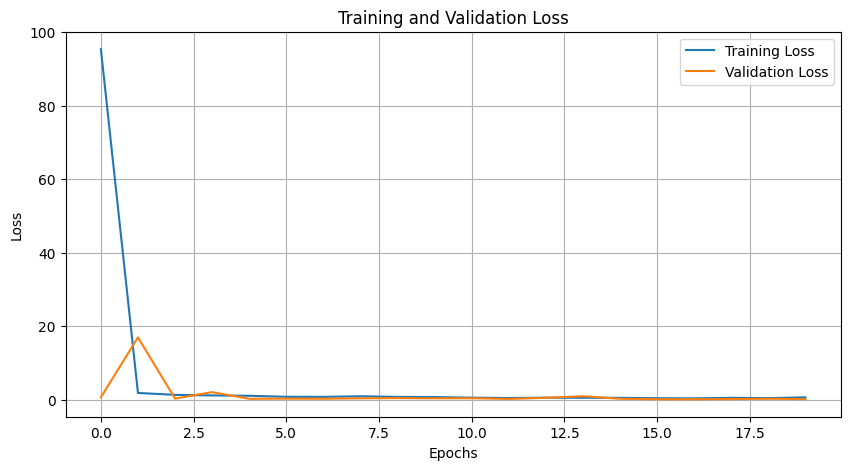

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
recon = autoencoder.predict(X)
mse = np.mean((X - recon)**2, axis=1)
threshold = np.percentile(mse[y==0], 95)
y_pred = np.where(mse > threshold, 1, 0)

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 2s 174us/step


In [21]:
num_anomalies = np.sum(y_pred == 1)
num_normals = np.sum(y_pred == 0)

print(f"Detected anomalies: {num_anomalies}")
print(f"Detected normal samples: {num_normals}")

print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print(f"Precision (Fraud class): {precision_score(y, y_pred)*100:.2f}%")
print(f"Recall (Fraud class): {recall_score(y, y_pred)*100:.2f}%")

Detected anomalies: 14637
Detected normal samples: 270170
Confusion Matrix:
 [[270099  14216]
 [    71    421]]
Precision (Fraud class): 2.88%
Recall (Fraud class): 85.57%


In [23]:
print("\nClassification Report:\n")
print(classification_report(y, y_pred, target_names=["Normal", "Fraud"]))


Classification Report:

              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97    284315
       Fraud       0.03      0.86      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.51    284807
weighted avg       1.00      0.95      0.97    284807



In [88]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np

# 1️⃣ Reconstruction
recon = autoencoder.predict(X)

# 2️⃣ Compute reconstruction error (MSE)
mse = np.mean((X - recon)**2, axis=1)

# 3️⃣ Threshold for anomaly detection
threshold = np.percentile(mse[y==0], 95)

# 4️⃣ Classify
y_pred = (mse > threshold).astype(int)

# 5️⃣ Evaluation
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print(f"Precision: {precision_score(y, y_pred)*100:.2f}%")
print(f"Recall: {recall_score(y, y_pred)*100:.2f}%")


print("\nClassification Report:\n")
print(classification_report(y, y_pred))#, target_names=["Normal", "Fraud"]))

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 2s 174us/step
Confusion Matrix:
 [[270099  14216]
 [    89    403]]
Precision: 2.76%
Recall: 81.91%

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.82      0.05       492

    accuracy                           0.95    284807
   macro avg       0.51      0.88      0.51    284807
weighted avg       1.00      0.95      0.97    284807

